In [4]:
import datetime
import pandas as pd
import sklearn
import numpy as np

pd.set_option("display.max_colwidth", 0)
pd.set_option("display.max_rows", 500)
pd.set_option("display.max_columns", 500)
pd.set_option("display.width", 1000)
import warnings
warnings.filterwarnings("ignore")
pd.options.display.float_format = '{:.5f}'.format

In [253]:
# load network data
df_road = pd.read_csv("data/TMC_Identification.csv", sep=',', header=0)
# df_road = df_road[['tmc_code','intersection','start_latitude','start_longitude','end_latitude','end_longitude','miles']]

from shapely.geometry import LineString
from geopandas import GeoDataFrame

df_road['geometry'] = df_road.apply(
    lambda row: LineString([(row['start_longitude'], row['start_latitude']),
                             (row['end_longitude'], row['end_latitude'])]),
    axis=1
)
gdf_road = GeoDataFrame(df_road, geometry='geometry',crs="EPSG:4326")
# gdf_road.head(2)
# gdf_road[gdf_road['direction'].isin(['EASTBOUND','SOUTHBOUND'])].explore(popup=True)

In [252]:
# route2 = ['112N05045', '112N05045','112-05045','112-05044', '112+13139', '112+13140', '112P13140', '112N05767', '112-05774', '112N05774', 
#           '112-05773',  '112-07906', '112-16998', '112P17004', '112+17005', '112N15305','112-15638','112+13138','112N15638'
#          ]

# route1 = ['112-05043', '112N05044', '112-05044','112N05045', '112-05045',
#           '112N05043', '112-05042','112N05042','112-05041', '112N05041', '112-05040','112N05040', '112-05039','112N05039','112N05038','112N07809',
#           '112-05038','112N07808','112-07808', '112P16911','112-07807','112N15306',
#          '112N07807', '112-07806', '112-07805', '112N07805', '112-06348', '112-06349', '112-15570', '112N15570','112-15639','112N15639',
#          '112-15305', '112N15305', '112-15638', '112N15638']

# gdf_road[gdf_road['tmc_code'].isin(route2)].explore(style_kwds={"weight": 5})

In [94]:
df_delay = pd.read_csv('./output/delay_diff_Saturday_morning_varying_demand.csv',header=0)

In [101]:
df_delay_select = df_delay[df_delay['minutes_since_midnight']==600]
gdf_road_weighted = gdf_road.merge(df_delay_select)
# gdf_road_weighted.to_file("./output/road_network.geojson", driver="GeoJSON")
gdf_road_weighted.head(2)

,tmc_code,intersection,start_latitude,start_longitude,end_latitude,end_longitude,miles,geometry,date,hour_min,minutes_since_midnight,delay_baseline,delay_focus,delay_difference,predicted_diff_delay,simulated_diff_delay_0.1,simulated_diff_delay_0.2,simulated_diff_delay_0.3,simulated_diff_delay_0.4,simulated_diff_delay_0.5,simulated_diff_delay_0.6,simulated_diff_delay_0.7,simulated_diff_delay_0.8,simulated_diff_delay_0.9,simulated_diff_delay_1.0
0,112P13033,W MARTIN LUTHER KING JR BLVD,30.28172,-97.74193,30.28232,-97.74207,0.04249,"LINESTRING (-97.74193 30.28172, -97.74207 30.28232)",2022-10-22,10:00,600,4.90736,-2.04473,-6.95209,-6.74248,-3.22840,-3.22840,-7.35475,-6.05193,-6.07216,-6.07597,-6.07185,-6.07185,-6.07185,-6.74248
1,112+08908,FM-20,30.11066,-97.41049,30.11082,-97.37323,2.22783,"LINESTRING (-97.41049 30.11066, -97.37323 30.11082)",2022-10-22,10:00,600,-7.15291,-5.44358,1.70934,-1.36938,-1.36938,-1.36938,-1.36938,-1.36938,-1.36938,-1.36938,-1.36938,-1.36938,-1.36938,-1.36938


# Convert geodataframe to graph

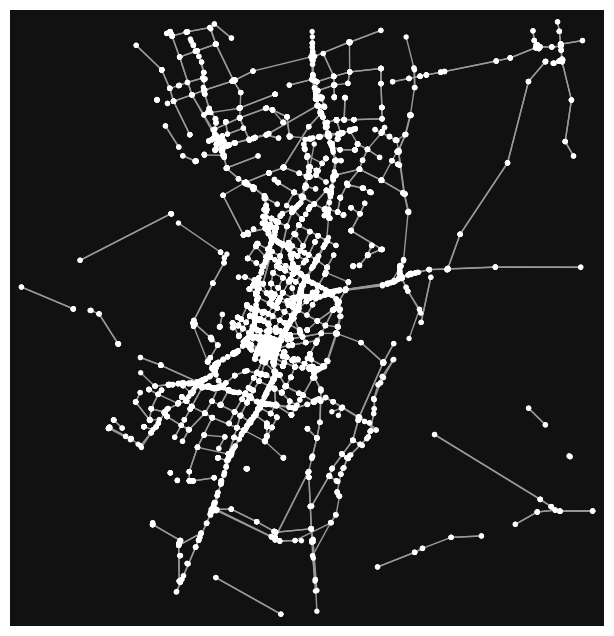

(<Figure size 800x800 with 1 Axes>, <Axes: >)

In [205]:
import networkx as nx
import geopandas as gpd
import osmnx as ox

# G = nx.MultiDiGraph()
G = nx.MultiGraph()
G.graph["crs"] = "EPSG:4326"  # WGS 84 coordinate reference system

# Initialize a mapping from tmc_code to integer node IDs
tmc_to_int_mapping = {}
next_node_id = 0  # Integer node ID counter

for _, row in gdf_road_weighted.iterrows():
    start_node = (row['start_longitude'], row['start_latitude'])
    end_node = (row['end_longitude'], row['end_latitude'])
    
    # Use tmc_code as part of the identifier but use an integer ID internally
    start_tmc_code = row['tmc_code'] + '01'
    end_tmc_code = row['tmc_code'] + '02'
    
    # Map the tmc_code to an integer node ID
    if start_tmc_code not in tmc_to_int_mapping:
        tmc_to_int_mapping[start_tmc_code] = next_node_id
        next_node_id += 1
    if end_tmc_code not in tmc_to_int_mapping:
        tmc_to_int_mapping[end_tmc_code] = next_node_id
        next_node_id += 1
    
    # Get the integer node IDs
    start_node_id = tmc_to_int_mapping[start_tmc_code]
    end_node_id = tmc_to_int_mapping[end_tmc_code]
    
    # Add nodes to the graph using integer IDs
    if start_node_id not in G:
        G.add_node(start_node_id, tmc_code=start_tmc_code, x=row['start_longitude'], y=row['start_latitude'])
    if end_node_id not in G:
        G.add_node(end_node_id, tmc_code=end_tmc_code, x=row['end_longitude'], y=row['end_latitude'])
    
    # Add edge with delay as weight
    delay = row['delay_difference']
    G.add_edge(start_node_id, end_node_id, weight=delay)

# Example of how to retrieve node's tmc_code (if needed later)
# for node in G.nodes(data=True):
#     print(f"Node {node[0]} has tmc_code {node[1]['tmc_code']}")

# Now plot the graph (optional)
ox.plot_graph(G)

In [209]:
def compute_network_distance(G, origin_coords, destination_coords):
    try:
        # Find the nearest nodes in the graph to the origin and destination coordinates
        origin_node = ox.distance.nearest_nodes(G, X=origin_coords[1], Y=origin_coords[0])  # (lat, lon)
        destination_node = ox.distance.nearest_nodes(G, X=destination_coords[1], Y=destination_coords[0])  # (lat, lon)
        print(origin_node, destination_node)
        length, path = nx.single_source_dijkstra(G, origin_node, target=destination_node, weight='weight')
        return length, path
    except nx.NetworkXNoPath:
        return float('inf'), []  # If no path exists between origin and destination

In [216]:
# %%time
# def snap_nodes(G, tolerance=0.001):
#     # Create a dictionary to store the snapped node positions
#     snapped_nodes = {}

#     for node, data in G.nodes(data=True):
#         x, y = data['x'], data['y']
#         snapped = False
#         for snapped_node, snapped_data in snapped_nodes.items():
#             if Point(x, y).distance(Point(snapped_data['x'], snapped_data['y'])) < tolerance:
#                 # Snap the current node to the already existing node
#                 G.nodes[node]['x'], G.nodes[node]['y'] = snapped_data['x'], snapped_data['y']
#                 snapped = True
#                 break
#         if not snapped:
#             # Add the node to the snapped dictionary
#             snapped_nodes[node] = {'x': x, 'y': y}

# # Apply the snapping to your graph
# snap_nodes(G)

In [210]:
origin_coords = (30.269958, -97.718087) 
destination_coords = (30.146599, -97.644116)

# Compute network distance for the given OD pair
distance, path = compute_network_distance(G, origin_coords, destination_coords)

# Output the result
if distance != float('inf'):
    print(f"The shortest network distance from {origin_coords} to {destination_coords} is {distance} meters (based on delay).")
    print("Path:", path)
else:
    print(f"No path exists between {origin_coords} and {destination_coords}.")

230 2495
No path exists between (30.269958, -97.718087) and (30.146599, -97.644116).


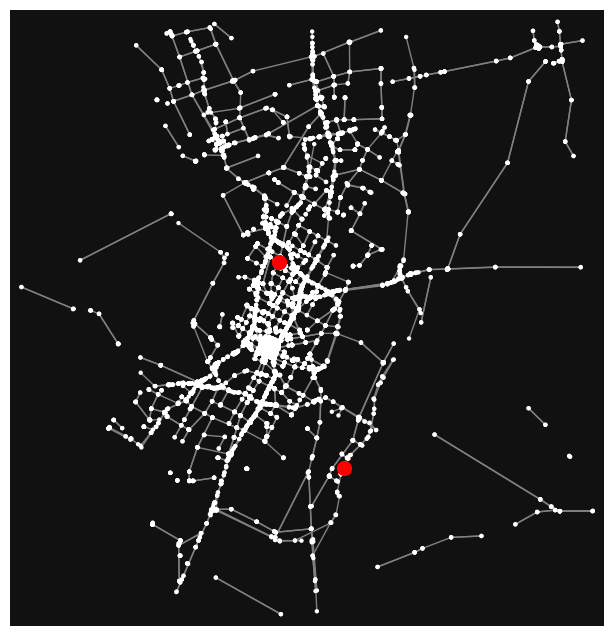

In [211]:
fig, ax = ox.plot_graph(G, node_size=10, edge_color='gray', edge_linewidth=1, show=False)

for node in [2000, 2495]:
    if node in G.nodes:
        x, y = G.nodes[node]['x'], G.nodes[node]['y']
        ax.scatter(x, y, color='red', s=100, zorder=5)  # Larger red dots for highlight

plt.show()